# Projet Lignes de niveau

On importe ces modules par principe de precaution

In [2]:
import autograd
from autograd import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

 Ceci est le notebook Jupyter contenant le projet de dessin de lignes de niveau sous python de Maud Roux-Salembien et Jérémy Costanzo

Soit f une fonction de $[0,1]^2$ vers $\mathbb{R}$ supposée continuement différentiable.

On cherche les ensembles de la forme : {$(x,y)\in\mathbb{R}^2|f(x,y)=c$} où c $\in$ $\mathbb{R}$

In [3]:
def f(x,y):
    return(x**2+y**2)
f(1,2)

5

## <u>Contour simple</u>

### Amorce : 

Soit c $\in$ $\mathbb{R}$

On cherche une condition suffisante sur f(0,0) et f(0,1) pour qu'il existe t $\in$ [0,1] tel que f(0,t) = c

On sait que f est continuement différentiable, donc en particulier f(0,.), qui désigne la fonction $\begin{align*}
  [0,1] &\to \mathbb{R}\\
  t &\mapsto f(0,t).
\end{align*}$
est continue.


Ainsi, si c appartient au segment [min(f(0,0),f(0,1)),max(f(0,0),f(0,1))], le théorème des valeurs intermédiaires nous assure l'existence d'un t $\in$ [0,1] solution de f(0,t) = c.

Si la condition évoquée est satisfaite, on peut chercher numériquement une solution en utilisant la méthode de la dichotomie :

In [4]:
def find_seed(g,c=0,eps=2**(-26)):
    if (g(0)-c)*(g(1)-c) > 0:
        return None
    else:
        a = 0
        b = 1
        while b-a > eps:
            m = (a+b)/2
            if (g(m)-c)*(g(a)-c)<=0:
                b = m
            else:
                a = m
        t = (a+b)/2
        return t

La méthode des tangentes de Newton converge plus rapidement, mais nécessite plus d'hypothèses, et on ne peut pas savoir à quel point on est éloigné d'une solution, alors que la méthode de la dichotomie ne nécessite que la continuité de g, et permet de majorer la distance à une solution.

### Propagation

Une première approche pour implémenter la fonction simple_contour consisterait à subdiviser [0,1] en segments de taille $\delta$, et d'utiliser find_seed(g,c,eps) où g est la fonction $\begin{align*}
  [0,1] &\to \mathbb{R}\\
  t &\mapsto f(k\delta,t)
\end{align*}$ où k varie de 0 à int(1/$\delta$). Mais cela n'est pas satisfaisant, il faudrait réaliser environ 1/$\delta$ dichotomies, et l'équation f(k$\delta$,t) = c peut admettre plusieurs solutions éloignées les unes des autres.

Pour la suite, nous avons besoin de calculer le gradient de f en un point. Ainsi nous implementons une classe pt qui permet de representer des elements de $\mathbb{R}^2$, donc des points ou des vecteurs.

In [5]:
tolerance = 1**(-12) #un petit flottant, choisi un peu au pif pour l'instant...

class pt:
    def __init__(self,x=0.0,y=0.0):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return('{'+str(self.x)+','+str(self.y)+'}')
        
    def __mul__(a,b):
        if isinstance(b,int) or isinstance(b,float):
            return pt(a.x*b,a.y*b)
        else:
            return pt(a.x*b.x,a.y*b.y)
            
    def __rmul__(a,b):
        if isinstance(a,int) or isinstance(a,float):
            return pt(a*b.x,a*b.y)
        else:
            return a*b
    def __neg__(self):
        return pt(-self.x,-self.y)
        
    def __add__(a,b):
        return pt(a.x+b.x,a.y+b.y)  
    
    def __inv__(self):
        return pt(1/self.x,1/self.y)
    
    def __div__(self,b):
        return (self * (1/b))
    
    def __rdiv__(self,b):
        return pt(b.x/self,b.y/self)
    
    def norme(self):
        return (self.x**2 + self.y**2)**0.5

    def normalized(self):
        return(self*(1/(self.norme())))
        
    def __sub__(self,b):
        return self+ (-b)
        
    def orth(self):
        return pt(-self.y,self.x)

def list_x_y(p):
    x,y = [],[]
    for i in p:
        x.append(i.x)
        y.append(i.y)
    return(np.array(x),np.array(y))
    
def dist(a,b):
    return (a-b).norme()
    
def ingrid(p,grid):
    return(grid[0]<=p.x<=grid[1] and grid[2]<=p.y<=grid[3])

def grad(p=pt()):
    g = autograd.grad
    t = np.r_[g(f,0)(p.x,p.y),g(f,1)(p.x,p.y)]
    return pt(t[0],t[1])

Nous implementons maintenant la fonction app : app(p,grid) renvoie : p $\in$ grid ou grid est en fait un ensemble de la forme [a,b]x[c,d] où (a,b,c,d) $\in \mathbb{R}^4$.


La fonction suivant est definie ainsi : suivant(ad,d,delta) est le point suivant de la ligne de niveau ou ad est l'avant dernier point calcule, d le dernier point calcule et delta est la distance entre les points de la ligne de niveau.

Cela nous permet d'implementer la fonction demandee, soit simple_contour(c,delta): on s'arrete de calculer des points si on revient au debut ou si les 3 derniers points calcules sont contenus dans un disque de diametre delta, car alors nous devenons imprecis (on peut imaginer que la ligne de niveau soit une spirale, ainsi on ne s'arreterait jamais de calculer des points).

On s'arrete aussi de calculer si on sort de la grille [0,1]x[0,1]

In [19]:
def app(p,grid):
    return(grid[0]<=p.x<=grid[1] and grid[2]<=p.y<=grid[3])

grid = [-1.,1.,-1.,1.]

def suivant(ad,d,delta):
    """
    trouver le prochain terme de la suite de newton
    """
    h=autograd.grad
    o=d+delta*pt(-h(f,0)(d.x,d.y),h(f,1)(d.x,d.y)).normalized()
    if not ingrid(o,grid):
        o=d-delta *pt(-h(f,0)(d.x,d.y),h(f,1)(d.x,d.y)).normalized()
    t=(o)
    dg=h(g,0)(t)
    if abs(abs(dg)-abs(g(o)*d))<e-12:
        if delta < tolerance:
            return d
        else :
            return suivant(ad,d/2,delta)
    else:
        return t-g(f,t,d)/dg

def g(f,theta,d) :
    return f(d*np.cos(theta),d*np.sin(theta))

    
def simple_contour(f,c=0.0,delta=0.01,grid=[0,1,0,1],cote=lambda x:f(grid[0],x)):
    t = find_seed(lambda x:f(grid[0],x),c)
    if t == None:
        return [],[]
    p0 = pt(grid[0],find_seed(cote,c))
    g0 = grad(p0)
    p11 = p0 + (g0.normalized().orth() * delta)
    p12 = p0 - (g0.normalized().orth() * delta)
    p1 = pt()
    if app(p11,grid):
        p1 = p11
    elif app(p12,grid):
        p1 = p12
    else:
        return [],[]
    p2 = suivant(p0,p1,delta)
    pts = [p0,p1,p2]
    pa = p0 #avant-avant dernier point calculé
    pb = p1 #avant-dernier
    pc = p2 #dernier point calculé
    while dist(pc,p0) > delta and dist(pc,pa) > delta and len(pts)<100000:
        while abs(pc-pb)>tolerance:
            pa=pb
            pb=pc
            pc = suivant(pb,pc,delta)
        if not ingrid(pc,grid):
            return list_x_y(pts)
        else:
            pts.append(pc)
    return list_x_y(pts)

TypeError: Can't differentiate w.r.t. type <class 'int'>

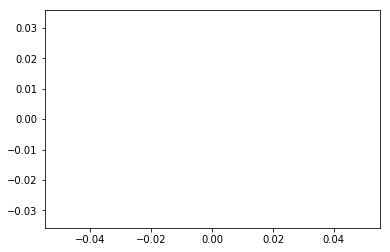

In [20]:
i = 5
plt.axis('equal')
def f(x,y) :
    return x**2+y**2
si = simple_contour(f,0.5,0.01)
plt.plot(si[0],si[1])